In [1]:
import os

import numpy as np
import pandas as pd

from math import ceil

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), f'output/vae_clustermaps')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
filt = main[main['VAE9-VAE20'] != -1]  # removes -1s in VAE9 and VAE20 clusterings

In [3]:
# Map VAE20 clusters to contexts
VAE20_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable3.csv'))
cell_context = [VAE20_annot['Call'][VAE20_annot['Cluster'] == i].values[0] for i in filt['VAE20']]
filt['context'] = [i for i in cell_context]
            
# Map VAE9 clusters to cell states
VAE9_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable4.csv'))
cell_state = [VAE9_annot['Call'][VAE9_annot['Cluster'] == i].values[0] for i in filt['VAE9']]
filt['state'] = [i for i in cell_state]

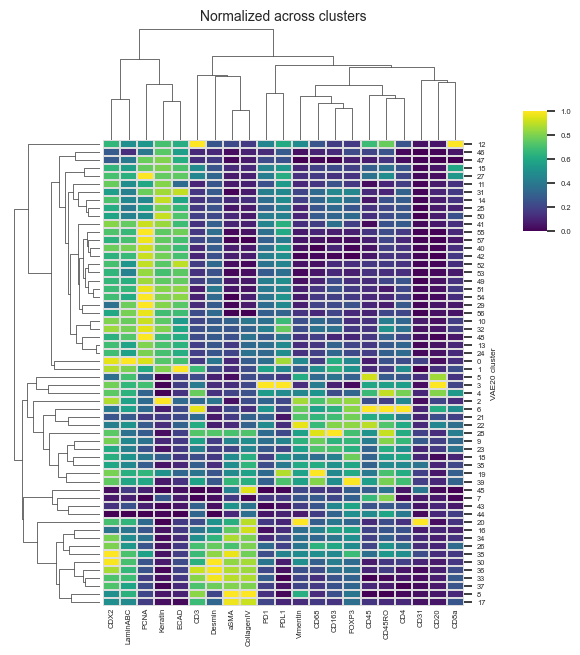

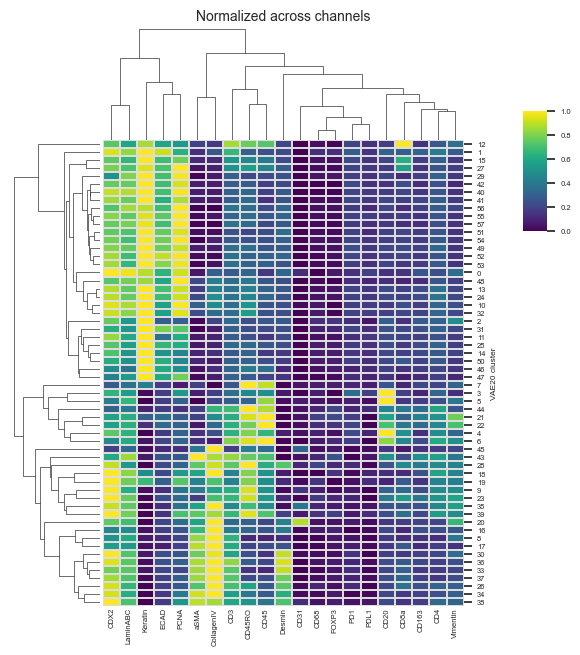

In [4]:
# Compute and plot segmentation-based average intensities for VAE20 clusters
abx_channels = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

clustermap_input = filt[list(abx_channels.keys()) + ['VAE20']].groupby('VAE20').mean()

sns.set(font_scale=0.5)
for name, axis in zip(['clusters', 'channels'], [1, 0]):

    g = sns.clustermap(
        clustermap_input, cmap='viridis', standard_scale=axis,
        figsize=(2, 30), xticklabels=1, yticklabels=1, linewidth=0.1,
        linecolor='gainsboro', cbar=True
    )
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
    g.ax_heatmap.set_ylabel('VAE20 cluster')
    g.ax_heatmap.set_xticklabels(
        [abx_channels[i.get_text()] for i in g.ax_heatmap.get_xticklabels()], rotation=90
    )
    g.ax_heatmap.get_xaxis().set_tick_params(pad=-5)
    g.ax_cbar.set_position([0.9, 0.65, 0.04, 0.2])
    g.fig.suptitle(f'Normalized across {name}', y=1.02, fontsize=10)
    g.fig.set_size_inches(6.0, 6.0)
    plt.savefig(
        os.path.join(out, f'VAE20_by_segmentation_intensity_norm_{name}.pdf'), bbox_inches='tight'
    )
    plt.show()
    plt.close('all')

In [ ]:
# Compute and plot patch-based average intensities for VAE20 clusters
markers = {
    0: 'CD3e', 1: 'CD45RO', 2: 'Keratin', 3: 'aSMA', 4: 'CD4', 5: 'CD45',
    6: 'PD1', 7: 'CD20', 8: 'CD68', 9: 'CD8a', 10: 'CD163', 11: 'FOXP3',
    12: 'PD-L1', 13: 'ECAD', 14: 'Vimentin', 15: 'CDX2', 16: 'LaminABC',
    17: 'Desmin', 18: 'CD31', 19: 'PCNA', 20: 'CollagenIV'
}

for rescale in [True, False]:
    for name, root in zip(
        ['VAE9-VAE20', 'VAE9', 'VAE20'],
        [
            '/Users/greg/projects/vae_manuscript/output/window_14/6_latent_space_LD184',
            '/Users/greg/projects/vae_manuscript/output/window_14/6_latent_space_LD184',
            '/Users/greg/projects/vae_manuscript/output/6_latent_space_LD850']
    ):

        print(f'Working on {name} rescale is {rescale}...')

        # Read combined training, validation, and test thumbnails
        combo_dir = os.path.join(root, 'combined_zarr')
        X_combo = zarr.open(combo_dir)
        X_combo = transposeZarr(X_combo)
        
        clustermap_input = pd.DataFrame(
            index=range(X_combo.shape[0]), columns=[i for i in markers.values()]
        )
        
        if rescale:
            # Perform 0-1 normalization for each channel within each image patch
            mins = X_combo.min(axis=(1, 2), keepdims=True)
            maxs = X_combo.max(axis=(1, 2), keepdims=True)
            X_combo = (X_combo - mins) / (maxs - mins)
            means = X_combo.mean(axis=(1, 2))
            import pdb; pdb.set_trace()
        else:
            means = X_combo.mean(axis=(1, 2))

        clustermap_input[:] = means
        clustermap_input = clustermap_input.astype('float32')
        import pdb; pdb.set_trace()
        clustermap_input[name] = main[name]
        clustermap_input['state'] = main['state']
        clustermap_input['context'] = main['context']
        clustermap_input['vae_tuple'] = main['VAE_Tuples']
        import pdb; pdb.set_trace()
        filt = clustermap_input[clustermap_input['VAE9-VAE20'] != -1]  # removes -1s in VAE9 and VAE20 clusterings
        
        linewidths = 0.1
        if name == 'VAE9-VAE20':
            sns.set(font_scale=0.3)
            plt.rcParams['xtick.major.pad'] = '0'
            plt.rcParams['ytick.major.pad'] = '0'
            linewidths = 0.0

            # Select high-abundance VAE tuple labels
            label_sizes = clustermap_input.groupby('VAE9-VAE20').size()
            selected_labels = label_sizes.index[label_sizes > 122]
            clustermap_input = clustermap_input[
                clustermap_input['VAE9-VAE20'].isin(selected_labels)
            ]
            import pdb; pdb.set_trace()
            # Compute median antibody signals for clusters
            clustermap_input = clustermap_input.groupby(
                [name, 'vae_tuple', 'state', 'context']).median()

            idx = clustermap_input.index
            clustermap_input.index = [
                r"$\bf{" 'L' + str(int(i[0])) + "}$" + ' — ' +
                r"$\bf{" 'S' + i[1].split('_')[0] + ': ' "}$" + i[2] + '; '
                r"$\bf{" 'C' + i[1].split('_')[1] + ': ' "}$" + i[3]
                for i in idx
            ]
        else:
            # Compute median antibody signals for clusters
            import pdb; pdb.set_trace()
            clustermap_input = clustermap_input.groupby(name).median()

        for norm, axis in zip(['clusters', 'channels'], [1, 0]):

            g = sns.clustermap(
                clustermap_input, cmap='viridis', standard_scale=axis,
                yticklabels=1, xticklabels=1, linewidths=linewidths,
                linecolor='grey', cbar=True, figsize=(6, 10)
            )

            g.ax_cbar.set_position([1.05, 0.75, 0.05, 0.2])
            g.fig.suptitle(f'Normalized across {norm}', y=1.03, fontsize=10)
            g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)

            plt.savefig(
                os.path.join(
                    out,
                    f'{name}_by_patch_intensity_norm_{norm}'
                    f'_rescale_{rescale}.pdf'), bbox_inches='tight'
            )
            plt.show()
            plt.close('all')
        print()

Working on VAE9-VAE20 rescale is True...
> /var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_33087/3245382947.py(39)<module>()
     37             means = X_combo.mean(axis=(1, 2))
     38 
---> 39         clustermap_input[:] = means
     40         clustermap_input = clustermap_input.astype('float32')
     41         import pdb; pdb.set_trace()



ipdb>  means


dask.array<mean_agg-aggregate, shape=(479909, 21), dtype=float64, chunksize=(200, 21), chunktype=numpy.ndarray>


ipdb>  X_combo


dask.array<truediv, shape=(479909, 14, 14, 21), dtype=float64, chunksize=(200, 14, 14, 21), chunktype=numpy.ndarray>


ipdb>  means


dask.array<mean_agg-aggregate, shape=(479909, 21), dtype=float64, chunksize=(200, 21), chunktype=numpy.ndarray>


ipdb>  clustermap_input


       CD3e CD45RO Keratin aSMA  CD4 CD45  PD1 CD20 CD68 CD8a  ... FOXP3  \
0       NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
1       NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
2       NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
3       NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
4       NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
...     ...    ...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
479904  NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
479905  NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
479906  NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
479907  NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
479908  NaN    NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   

       PD-L1 ECAD Vimentin CDX2 LaminABC Desmin CD31 PCNA CollagenIV  
0        NaN  Na

ipdb>  means


dask.array<mean_agg-aggregate, shape=(479909, 21), dtype=float64, chunksize=(200, 21), chunktype=numpy.ndarray>


ipdb>  clustermap_input[:] = means


/Users/greg/venvs/vae/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


ipdb>  clustermap_input


            CD3e    CD45RO   Keratin      aSMA       CD4      CD45       PD1  \
0       0.334825  0.499296  0.285668  0.476264  0.358978  0.421098   0.51197   
1       0.416468   0.52506  0.224616  0.456778  0.506995  0.472225   0.46661   
2       0.523679  0.207041  0.340203  0.361564  0.318643  0.234256  0.391782   
3       0.202896  0.212459  0.471628  0.207647   0.23544  0.309194  0.338716   
4       0.274128  0.195809  0.490894  0.133635  0.284751   0.22253  0.442345   
...          ...       ...       ...       ...       ...       ...       ...   
479904  0.435226  0.174589  0.482525  0.375252  0.512764  0.547941  0.398047   
479905  0.277043  0.397548  0.434163  0.263799  0.229031  0.353663  0.277003   
479906  0.340013  0.364782  0.496579   0.29228   0.24473  0.273156  0.198718   
479907  0.423045  0.248048  0.377277  0.089933  0.247949   0.27658  0.452389   
479908   0.51474  0.428999  0.310579  0.368957  0.430969  0.433072  0.365373   

            CD20      CD68      CD8a  .

ipdb>  means


dask.array<mean_agg-aggregate, shape=(479909, 21), dtype=float64, chunksize=(200, 21), chunktype=numpy.ndarray>


ipdb>  clustermap_input.isnull().any()


CD3e          False
CD45RO        False
Keratin       False
aSMA          False
CD4           False
CD45          False
PD1           False
CD20          False
CD68          False
CD8a          False
CD163         False
FOXP3         False
PD-L1         False
ECAD          False
Vimentin      False
CDX2          False
LaminABC      False
Desmin        False
CD31          False
PCNA          False
CollagenIV     True
dtype: bool


ipdb>  means


dask.array<mean_agg-aggregate, shape=(479909, 21), dtype=float64, chunksize=(200, 21), chunktype=numpy.ndarray>


ipdb>  means[:,20]


dask.array<getitem, shape=(479909,), dtype=float64, chunksize=(200,), chunktype=numpy.ndarray>


ipdb>  np.isnan(means[:,20])


dask.array<isnan, shape=(479909,), dtype=bool, chunksize=(200,), chunktype=numpy.ndarray>


ipdb>  np.isnan(means[:,20]).any()


dask.array<any-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


ipdb>  np.isnan(means[:,20]).any().compute()


/Users/greg/venvs/vae/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


True


ipdb>  np.isnan(means[:,19]).any().compute()


/Users/greg/venvs/vae/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


False


ipdb>  X_combo = zarr.open(combo_dir)
ipdb>  X_Combo


*** NameError: name 'X_Combo' is not defined


ipdb>  X_combo


<zarr.core.Array (21, 479909, 14, 14) uint16>


ipdb>  X_combo = transposeZarr(X_combo)
ipdb>  X_combo


dask.array<transpose, shape=(479909, 14, 14, 21), dtype=uint16, chunksize=(200, 14, 14, 21), chunktype=numpy.ndarray>


ipdb>  X_combo[:, :, :, 20]


dask.array<getitem, shape=(479909, 14, 14), dtype=uint16, chunksize=(200, 14, 14), chunktype=numpy.ndarray>


ipdb>  np.isnan(X_combo[:, :, :, 20])


dask.array<isnan, shape=(479909, 14, 14), dtype=bool, chunksize=(200, 14, 14), chunktype=numpy.ndarray>


ipdb>  np.isnan(X_combo[:, :, :, 20]).any().compute()


False
